# Person Re-Identification with FastReID and YOLOv5

This notebook demonstrates person re-identification using the FastReID library and YOLOv5 for object detection.
The goal is to identify the same person across different images or video frames.

The notebook is structured as follows:
1. **Installation:** Install necessary libraries.
2. **Model Loading:** Load the FastReID and YOLOv5 models.
3. **Inference:** Perform inference using YOLOv5 for person detection and FastReID for feature extraction.
4. **Search Loop:** Compare features and identify the same person across images.


# Installation

In [ ]:
# Clone FastReID repository and install dependencies
!git clone https://github.com/JDAI-CV/fast-reid
%cd fast-reid
!pip install -r docs/requirements.txt

from fastreid.config import get_cfg
from fastreid.engine import default_setup
from fastreid.modeling import build_model as fast_build

In [ ]:
import os
import cv2
import torch
import numpy as np
from PIL import Image
import matplotlib.pyplot as plt
import torchvision.transforms as transforms
import time

In [ ]:
# Fast distance calculation
!pip insall hexhamming
from hexhamming import hamming_distance_bytes

# Model loading

In [32]:
def load_fastreid_model(model_name):
    """
    Loads a FastReID model from a specified path.

    Args:
        model_name (str): Name of the model file.

    Returns:
        torch.nn.Module: Loaded FastReID model.
    """
    model_path = f"{model_name}.pth"
    config_path = "configs/Market1501/bagtricks_R50-ibn.yml"

    # Initialize config
    cfg = get_cfg()
    cfg.merge_from_file(config_path)
    cfg.merge_from_list(['MODEL.WEIGHTS', model_path, 'MODEL.DEVICE', 'cpu'])
    cfg.MODEL.BACKBONE.PRETRAIN = False
    cfg.freeze()

    # Pass args if any
    default_setup(cfg, args={})

    # Build and load model
    model_reid = fast_build(cfg)
    state_dict = torch.load(model_path, map_location='cpu')['model']

    # Rename and load state dict
    renamed_state_dict = {k.replace('heads.bnneck', 'heads.bottleneck.0') if k.startswith('heads.bnneck') else k: v for k, v in state_dict.items()}
    model_reid.load_state_dict(renamed_state_dict, strict=False)

    return model_reid

In [ ]:
!wget https://github.com/JDAI-CV/fast-reid/releases/download/v0.1.1/market_bot_R50-ibn.pth

In [ ]:
model_reid = load_fastreid_model("market_bot_R50-ibn")

In [ ]:
model_yolo = torch.hub.load('ultralytics/yolov5', 'yolov5m', pretrained=True)

# Inference


In [34]:
# Load and store images (preferably containing the same people captured from different angles)
image_paths = ['/content/Screenshot1.png', '/content/Screenshot3.png']
images = []
for path in image_paths:
    image = cv2.imread(path)
    images.append(image)
    print(f"Image {'loaded successfully' if image is not None else 'failed to load'}")

Image loaded successfully
Image loaded successfully


In [3]:
def extract_people_images(image, model_yolo):
    """
    Performs inference on an image using YOLOv5 and extracts images of detected people.

    Args:
        image (numpy.ndarray): Image to perform inference on.
        model_yolo (torch.nn.Module): YOLOv5 model.

    Returns:
        list: A list of image arrays containing detected people.
    """
    # Convert to RGB
    image_rgb = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)

    # Inference
    results = model_yolo(image_rgb)

    # Extract results for 'person' class
    results = results.xyxy[0]  # xyxy format: x1, y1, x2, y2, confidence, class
    people_boxes = results[results[:, -1] == 0]  # Filter for 'person' class

    # Crop and collect images of detected people
    people_images = []
    for box in people_boxes:
        x1, y1, x2, y2 = map(int, box[:4])
        # Ensure coordinates are within image dimensions
        x1, y1, x2, y2 = max(x1, 0), max(y1, 0), min(x2, image_rgb.shape[1]), min(y2, image_rgb.shape[0])
        crop_img = image_rgb[y1:y2, x1:x2]
        if crop_img.size > 0:
            people_images.append(crop_img)

    return people_images

def display_cropped_images(people_images):
    """
    Displays a list of cropped images.

    Args:
        people_images (list): List of cropped image arrays.
    """
    # Visualize detected people
    if people_images:
        plt.figure(figsize=(15, 15))
        for i, person_img in enumerate(people_images):
            ax = plt.subplot(1, len(people_images), i + 1)
            plt.imshow(person_img)
            plt.axis('off')
        plt.show()
    else:
        print("No people detected")


def extract_features(cropped_images, model, resize_dim=(64, 128), device='cpu'):
    """
    Performs inference on a list of image arrays using a specified model.

    Args:
        cropped_images (list): List of cropped image arrays.
        model (torch.nn.Module): Model to use for feature extraction.
        resize_dim (tuple): Dimensions to resize images to.
        device (str): Device to run inference on.

    Returns:
        torch.Tensor: A tensor of feature vectors extracted by the model.
    """
    # Preprocess images
    tensors = []
    for img_array in cropped_images:
        # Resize image and convert to tensor
        resized_img = cv2.resize(img_array, resize_dim, interpolation=cv2.INTER_LINEAR)
        img_tensor = torch.from_numpy(resized_img.transpose(2, 0, 1)).float() / 255.0
        tensors.append(img_tensor)

    # Stack tensors and move to the specified device
    images_tensor = torch.stack(tensors).to(device)

    # Prepare model and perform inference
    model = model.eval().to(device)
    start_time = time.time()
    with torch.no_grad():
        features = model(images_tensor)
    total_time = time.time() - start_time

    print(f"Inference time: {total_time:.4f}s")
    return features

/root/.cache/torch/hub/ultralytics_yolov5_master/models/common.py:892: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with amp.autocast(autocast):
/root/.cache/torch/hub/ultralytics_yolov5_master/models/common.py:892: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with amp.autocast(autocast):


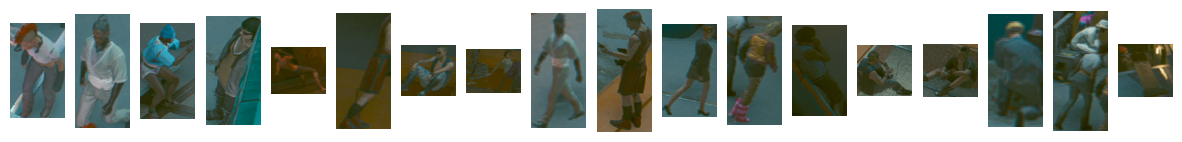

In [35]:
# YOLO inference
cropped_images = infer_on_image(images[0], model_yolo)
cropped_images.extend(infer_on_image(images[1], model_yolo))

%matplotlib inline
display_cropped_images(cropped_images)

In [27]:
# ReID inference
features = extract_features(cropped_images, model_reid)
print(f"size: {features.size()}")
print(f"min: {features.min()}")
print(f"max: {features.max()}")
print(f"mean: {features.mean()}")
print(f"std: {features.std()}")

Inference time: 4.6293s
size: torch.Size([16, 2048])
min: -2.0163469314575195
max: 8.80534553527832
mean: -0.15875382721424103
std: 0.7706342935562134


# Search Loop


In [28]:
def convert_to_bytes(features):
    """Converts feature vectors to bytes representation for efficient comparison."""
    bool_feats = features >= 0
    return bytes(np.packbits(bool_feats))

def update_gallery(gallery_features, gallery_images, gallery_ids, new_feature, new_image):
    """Updates the gallery with a new feature, image and id."""
    new_id = len(gallery_ids)
    gallery_features.append(new_feature)
    gallery_images.append(new_image)
    gallery_ids.append(new_id)
    return new_id

def find_closest_matches(gallery_features, query_feature, num_matches=3):
    """Finds the closest matches to a query feature in the gallery."""
    if not gallery_features:
        return [], []
    query_bytes = convert_to_bytes(query_feature)
    gallery_bytes = [convert_to_bytes(gallery_feat) for gallery_feat in gallery_features]
    distances = [hamming_distance_bytes(query_bytes, gallery_byte) for gallery_byte in gallery_bytes]
    closest_indices = sorted(range(len(distances)), key=lambda i: distances[i])[:num_matches]
    closest_distances = [distances[i] for i in closest_indices]
    return closest_indices, closest_distances

def display_closest_images(query_image, query_feature, closest_indices, gallery_images, gallery_features, distances, gallery_ids):
    """Displays the query image and its closest matches from the gallery."""
    plt.figure(figsize=(10, 5))

    # Display the query image
    ax = plt.subplot(1, len(closest_indices) + 1, 1)
    plt.imshow(query_image)
    plt.title("Query")
    plt.axis('off')

    # Display closest match images with distances and IDs
    for i, index in enumerate(closest_indices):
        person_img = gallery_images[index]
        ax = plt.subplot(1, len(closest_indices) + 1, i + 2)
        plt.imshow(person_img)
        plt.title(f"ID {gallery_ids[index]}\nDist: {distances[i]:.2f}")
        plt.axis('off')

    plt.show()


In [29]:
def main(query_features, query_images):
    """Main function to perform person re-identification."""
    # Initialize empty gallery
    gallery_features, gallery_images, gallery_ids = [], [], []

    for feature, image in zip(query_features, query_images):
        # If the gallery is empty, add the first feature and image directly
        if not gallery_features:
            new_id = update_gallery(gallery_features, gallery_images, gallery_ids, feature, image)
            print(f"Gallery is empty. Added feature with ID {new_id}.")
        else:
            closest_indices, closest_distances = find_closest_matches(gallery_features, feature)
            display_closest_images(image, feature, closest_indices, gallery_images, gallery_features, closest_distances, gallery_ids)

            # Check if the closest match is within the distance threshold
            if closest_distances and min(closest_distances) <= 50:
                closest_ids = [gallery_ids[index] for index in closest_indices]
                print(f"Closest matches: {closest_ids} with distances {closest_distances}")
            else:
                # Add the new feature and image to the gallery if no close match is found
                new_id = update_gallery(gallery_features, gallery_images, gallery_ids, feature, image)
                print(f"No close match found. Added new feature with ID {new_id} to gallery.")



Gallery is empty. Added feature with ID 0.


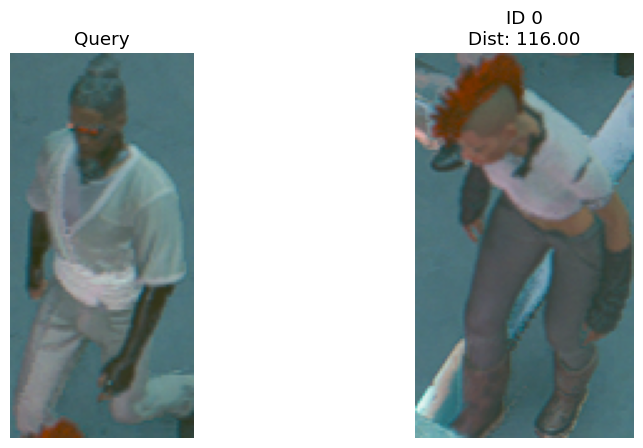

No close match found. Added new feature with ID 1 to gallery.


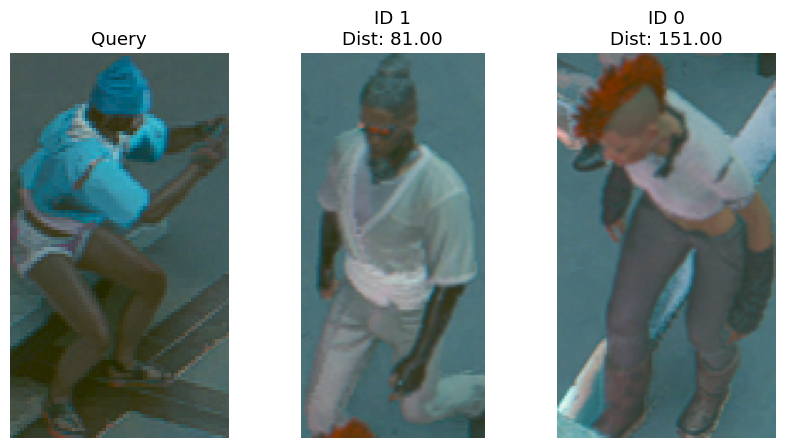

No close match found. Added new feature with ID 2 to gallery.


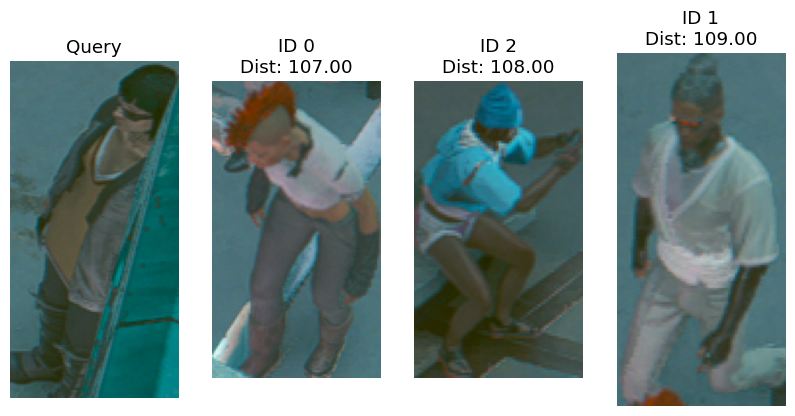

No close match found. Added new feature with ID 3 to gallery.


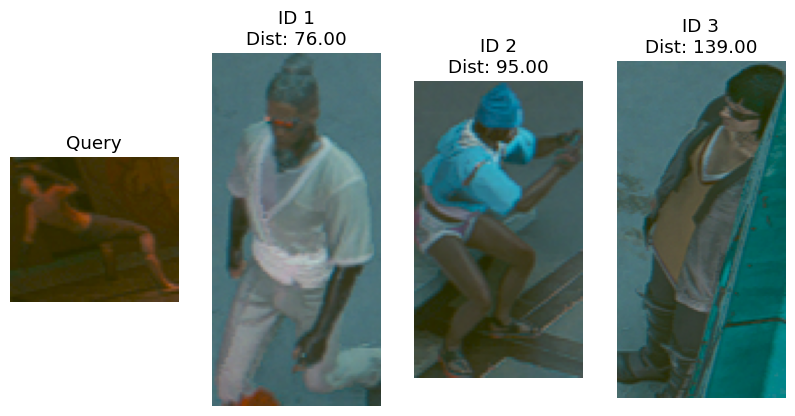

No close match found. Added new feature with ID 4 to gallery.


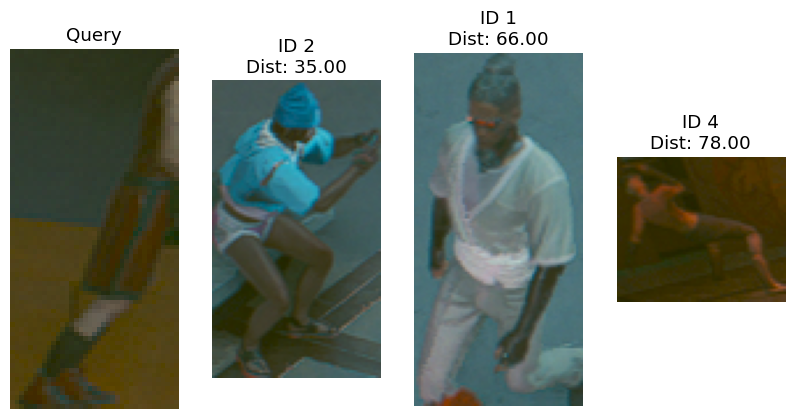

Closest matches: [2, 1, 4] with distances [35, 66, 78]


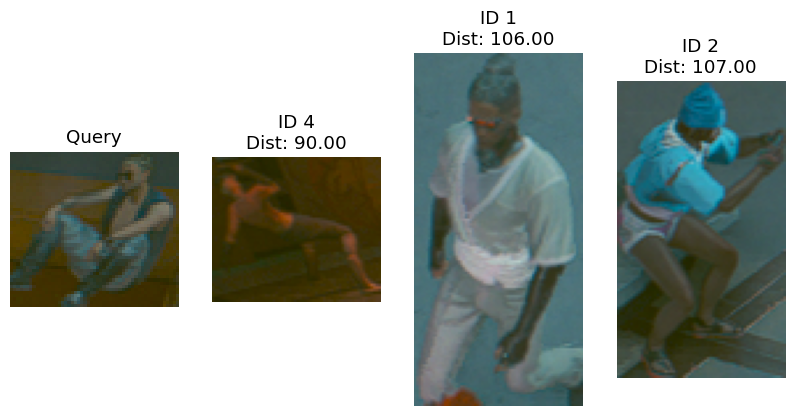

No close match found. Added new feature with ID 5 to gallery.


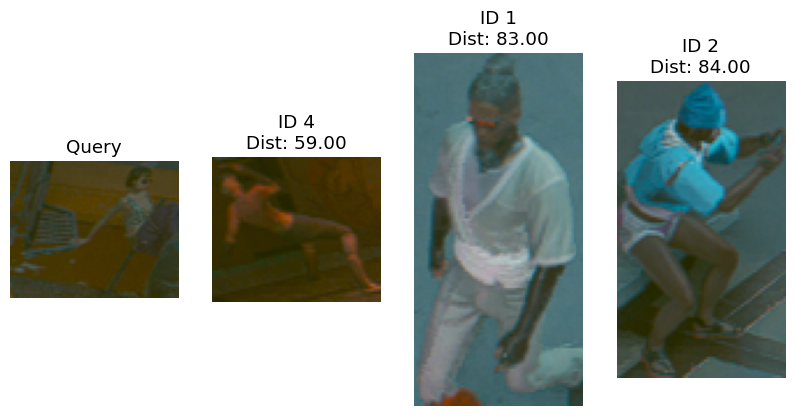

No close match found. Added new feature with ID 6 to gallery.


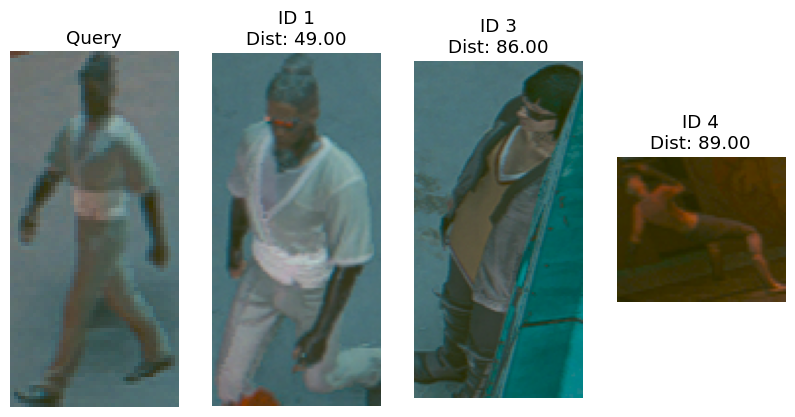

Closest matches: [1, 3, 4] with distances [49, 86, 89]


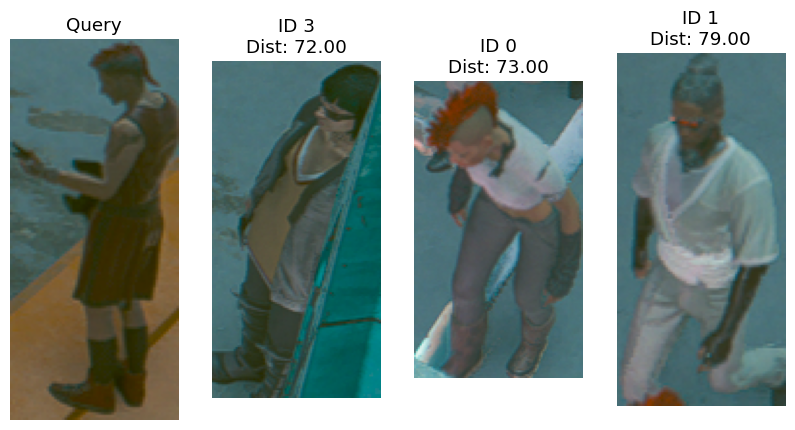

No close match found. Added new feature with ID 7 to gallery.


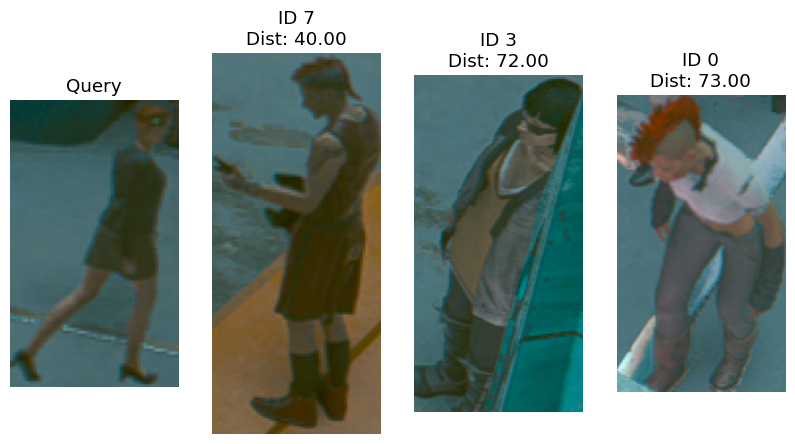

Closest matches: [7, 3, 0] with distances [40, 72, 73]


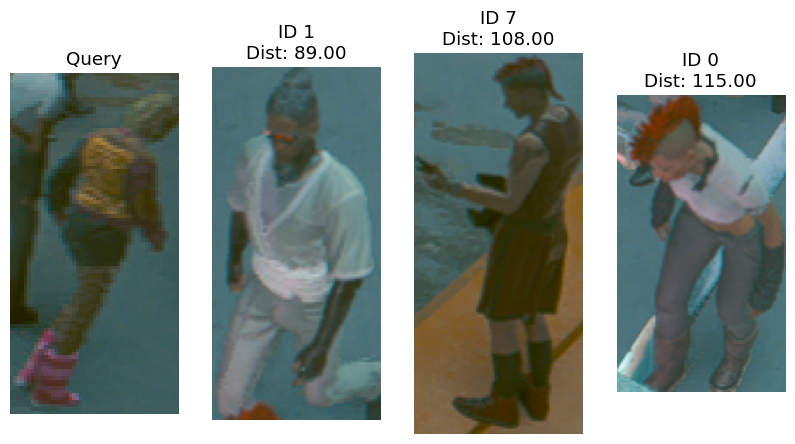

No close match found. Added new feature with ID 8 to gallery.


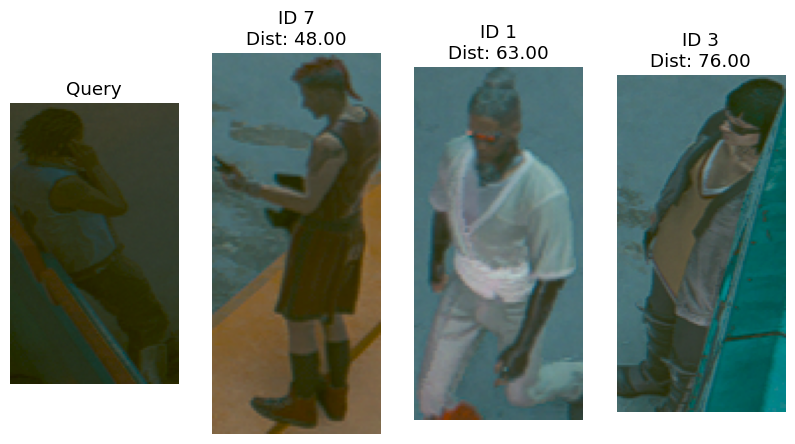

Closest matches: [7, 1, 3] with distances [48, 63, 76]


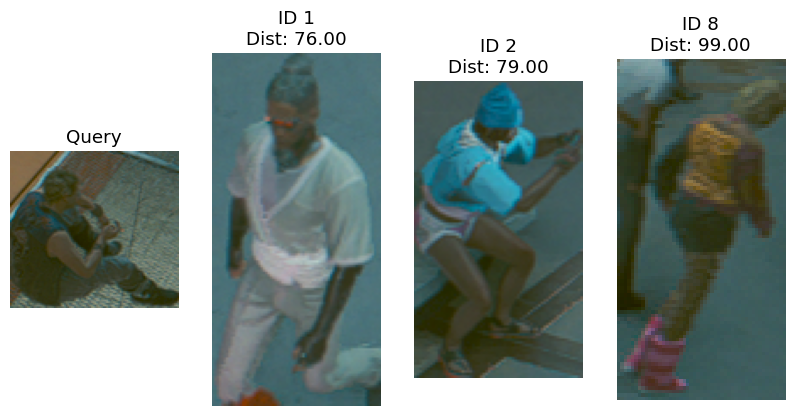

No close match found. Added new feature with ID 9 to gallery.


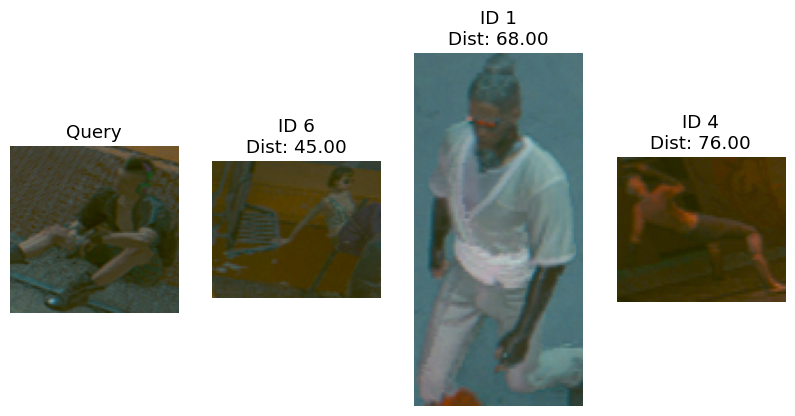

Closest matches: [6, 1, 4] with distances [45, 68, 76]


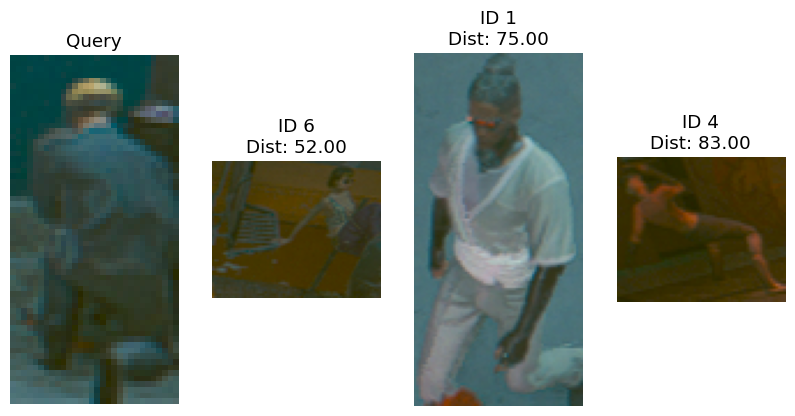

No close match found. Added new feature with ID 10 to gallery.


In [36]:
# Example usage with extracted features and cropped images
main(features, cropped_images)